# Procedural Generation of Networks
> __Purpose__: The goal of this notebook is to construct a way of 1) representing the activity of neural networks in terms of its baseline parameters (gating variables, voltages, synaptic couplings), and 2) finding a way to then compress that "graph" into an ODE that can be fed to odeint such that a solution to the given network can be found.  Specifically, this NB will build on the code from NB 11 and attempt to generate a "skeleton network" such that the code from NB 11 is essentially refactored (everything is functionalized in order to provide the ability to iterate/loop arbitrarily for the number of neurons in the network).

## 7/9 Advice
- Work backwards. That is, think about a function that outputs on ODE RHS given an exact specification of the parameters, polynomial forms, and so on, for a specified dynamical system. Then think about how to randomly generate this parameters. The key thing for you to focus on is how to represent the graph that I drew as an ODE.

# Current Progress
## Case1: 1 Neuron (Recreation of Previous Results)
1. Finished, replicates previous results

## Case2: 2 Neurons (Recreation of Previous Results)
1. Updated code and now oscillations are gone.  Working on recreating them.
2. Mostly automatic: requires numNodes specified ...

## Case3: 3 Neurons
1. Generalizations from 2 Neuron case should carry over, would need to investigate values for synaptic couplings, possibly current
2. Successful generation, granted the 3rd Neuron does not follow the first two for some reason

## Imports

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Functions From Previous NBs

In [2]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

In [3]:
def plot_vnmh(x,t,numNodes,gatingVars=False):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
        numNodes:
        gatingVars:
    '''
    node_length = 21+(numNodes-1)
    V = np.zeros((numNodes, len(t)))
    n = np.zeros((numNodes, len(t)))
    m = np.zeros((numNodes, len(t)))
    h = np.zeros((numNodes, len(t)))
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15
    
    #Extract variables from matrix
    for node in range(numNodes):
        V[node] = x[node_length*node,:]
        n[node] = x[node_length*node+1,:]
        m[node] = x[node_length*node+2,:]
        h[node] = x[node_length*node+3,:]

    #Now plot the voltage graph:
    plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
    plt.ylabel("Volts (mV)", fontsize=label_font)
    plt.xlabel("Time (ms)", fontsize=label_font)
    for node in range(numNodes):
        NeuronNum = 'Neuron ' + str(node+1)
        plt.plot(t,V[node],label=NeuronNum)
    leg = plt.legend(loc='upper right')
    for text in leg.get_texts():
        text.set_color('black')
    plt.show()

    if gatingVars:
        plt.figure(figsize=(15,10))
        plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        
        #Should probably just plot n's together or something... otherwise too many curves on one plot
        my_label = [0]*3
        for node in range(numNodes):
            my_label[0] = 'n' + str(node+1)
            my_label[1] = 'm' + str(node+2)
            my_label[2] = 'h' + str(node+3)
            
            plt.plot(t,n[node],label=my_label[0])
            plt.plot(t,m[node],label=my_label[1])
            plt.plot(t,h[node],label=my_label[2])

        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()

## Refactoring of odes_sigmoid from NB 11 into odes_progen (Procedural Generation)

In [4]:
#Functions replacing non-functionalized calls from odes_sigmoid

def tau_func(V, mean):
    '''
    Function which returns the time constant for the associated variable
    Note that currently we are ignoring the "bump" in the true Tau functions and instead
    simply returning the mean.  The mean has been precalculated and will just be passed
    in and out for form's sake.
    
    In the future may switch to represent Tau functions as Gaussians (which they appear to be), but
    this would require extra parameters (i.e. instead of mean would need the center, width, and upwards bias)
    '''
    return mean


def inf_func(V, v0, sigma):
    '''
    Approximates the "quasi-Steady-State" ie the x_inf values, using sigmoid functions
    
    Params:
        v0: v initial value, changes x coord of center, essentially
        sigma: "rate" (technically 1/sigma is the rate) --> big sigma means gradual change (i.e. less steep slope)
    '''
    
    if v0==0 and sigma==0:
        #Avoid division by 0
        x_inf = 0
    else:
        x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
    return x_inf 


def diffEQ_func(tau, x_inf, x):
    '''
    ie dndt, dmdt, dhdt
    Uses the canonical self linear form, such that dxdt = G(x) * (E(x) - V)
    '''
    if tau==0:
        #Avoid division by 0
        dxdt = 0
    else:
        #for the base equations is just
        dxdt = (1/tau)*(x_inf - x)
    return dxdt

## Additional Utility Functions for Scalability

In [5]:
def check_SC(current_node,numNodes):
    '''
    Function that checks the synaptic couplings for a given node
    
    Params:
        current_node: node for which you want to retrieve the SCs
        numNodes: uses this as a proxy to choose the file.  Obvious downsides with this but this was the quickest way to test
        
    Returns:
        SC_dict: dictionary of form {NodeCoupledTo: ValueOfCoupling}
            e.g. if Neuron 1 is coupled to Neuron 2, its SC_dict is {2: s2}
            e.g. if Neuron 1 is coupled to Neuron 2 and 3, its SC dict is {2: s2, 3: s3}, ad nauseam
    '''
    
    if numNodes==1:
        return 0
    else:
        basepath = 'C:\\users\\14193\\desktop\\summer2021\\brown\\hh-comp\\NetworkCouplingParams\\'
        my_file = str(numNodes) + 'Neurons'
        file_ext = '.txt'
        fullpath = basepath + my_file + file_ext
    
    lineNum = 0
    with open(fullpath, 'r') as file_obj:
        for line in file_obj:        
            if lineNum==current_node:
                as_list = line.split(", ")
                break
            lineNum += 1
            
        SC_dict = dict()
        for idx in range(len(as_list)):
            if (idx%2==0):
                SC_dict[as_list[idx]]= as_list[idx-1]
    
    return SC_dict


def calc_conx(numNodes):
    '''
    Recursive function to calculate the maximum number of connections for a networks of numNodes nodes
    Rule: The number of connections = the number of connections for a network of 1 node smaller + number of nodes for a network of 1 node smaller than the desired network
    Note further that the point of this is to tell how many values must be passed in for odes_progen for number of SC vars (ie. the number of SC diffEQs that this should solve)
    '''
    if numNodes==1:
        conx = 0
    else:
        conx = (numNodes-1) + calc_conx(numNodes-1)
    return conx

Odes_progen for procedural generation of action potentials

In [6]:
def odes_progen(x,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x: all network parameters
        t: time vector, not called in func but regardless (but used in odeint)
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''
    
    ######### DEFINITIONS #########
    
    ### THIS IS MANUALLY SET AND MUST MATCH THE INPUT ###
    maxParams = 5 #Takes advantage of the fact that there will be a tau, v0, inf, etc. for each gating var
    #^ ie we can keep reusing this since there will be the same number of parameters necessary for each gating var
    #This is quasi-manual, based on the maxParams being 5... could probably make the equation itself automated?
    p = [1,20,-len(x)]
    roots = np.roots(p)
    numNodes = int(roots[1])

    numSC = numNodes-1 #calc_conx(numNodes)*2 <-- This is the total number of connections, but we only need to pass the max number of connections per node in for each node
    ES = [0] * numSC #ENa #mV #Excitatory Neuron (by this definition)
    
    #Convert list input into a matrix
    numParams = 1+4*maxParams+numSC #In this current form, there are 26 parameters per node.  I.e. 1 node is (1,26)
    x = np.reshape(x,(numNodes,numParams))
    
    if len(x.shape)==1:
        #Ie if it is 1D, expand the dim to be (1,X) so that we can index as if it were 2D
        x = np.expand_dims(x,0)
        
    firstSIndex = numParams-numSC
    
    infs = np.zeros((numNodes,maxParams))
    taus = np.zeros((numNodes,maxParams))
    dxdts = np.zeros((numNodes,numParams)) #ONE FOR EACH VAR PASSED IN THROUGH Y0

    ######### CONSTANTS #########
    CmBase = 0.01 #uF
    #Altering the current for the nodes, essentially weighting them
    #In the test trials in NB 10, we used 1x for node1, and 0x for node2
    node_current = [0]*numNodes
    node_current[0] = 1
    if numNodes>1:
        #Do something more advanced later
        node_current[1] = 0
    node_current = np.array(node_current)*(1/CmBase)
    
    #For the synaptic coupling: 
    #^20 was a "good value" (ie one for which it functioned) in the previous NB
    gbars = [20] * numSC
    
    ######### LOOPING #########
    
    for nodeTemp in range(numNodes):  
        #Weighting matrix
        #WM = np.random.randint(low=998,high=1002,size=maxParams*4+1)/1000
        #Always breaks when doing it the above method
        WM = [1]*(maxParams*4+1)
        
        #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
        #reversal potentials
        ENa = 55.17*WM[0] #mV
        EK = -72.14*WM[1] #mV
        EL = -57.99*WM[2] #-49.42 #mV
        #E4
        #E5
        #membrane capacitance
        Cm = CmBase*WM[5] #uF/cm^2
        
        #conductances (S is Siemens)
        gbarK = 0.36*WM[6] #mS/cm2
        gbarNa = 1.2*WM[7] #mS/cm2
        gbarL = 0.003*WM[8] #mS/cm2
        #So really there should be other values here for the 4th and 5th gating variables should those get used
        #gbar?(4) = ___
        #gbar?(5) = ___

        #For now, defining every neuron the same, but can change the "n,m,h" values...
        gK = (1/Cm)*gbarK*(x[nodeTemp,1]**4) #Why did I have a +maxParams after the 1?
        gNa = (1/Cm)*gbarNa*(x[nodeTemp,2]**3)*x[nodeTemp,3]
        gL = (1/Cm)*gbarL
        #Again, would need to add something for the 4th and 5th gating variables should they exist
        #...
        
        #Simplification: check connection in external function
        vnode_couplings = []
        svars = []   
        if numNodes==1:
            svars = [0]*numSC #1 neuron, so no connections.  Just return 0s
        else:
            SC_repo = check_SC(nodeTemp,numNodes) #RETURNS A DICTIONARY   

            if SC_repo is not None and len(SC_repo)>0:
                for idx in range(numNodes):
                    idx = str(idx + 1) #Adjust for offset, first node is 1 not 0
                    if SC_repo.get(idx) is not None:
                        adj_idx = int(idx)-1
                        vnode_couplings.append(adj_idx) #This is the node that it is coupled to
                        sval = float(SC_repo.get(idx))
                        svars.append(sval) #This is the s val, to be used in gs

                #Don't think this loop should actually ever run anymore
                while len(svars)<numSC:
                    vnode_couplings.append(0)
                    svars.append(0)

                my_zeros = [0]*(firstSIndex) #Ie a 1,21 vector of zeros, so once we add the 5 couplings to it, it meets 26
                svars_full = my_zeros+svars
                vnode_couplings_full = my_zeros+vnode_couplings
            else:
                print("Error: SC_repo returned None")
        gs = np.array(gbars) * np.array(svars) #* (1/Cm)

        #Define the steady state (inf) values, and the time constants (tau)
        #Note that this must be completed first, so that all the taus, infs are defined before we can make the ODEs
        for param in range(maxParams):
            #inf(V, v0, sigma)
            infs[nodeTemp,param] = inf_func(x[nodeTemp,0], x[nodeTemp,param+(1+maxParams)], x[nodeTemp,param+(1+2*maxParams)])
            #tau(V, mean)
            taus[nodeTemp,param] = tau_func(x[nodeTemp,0], x[nodeTemp,param+(1+3*maxParams)])

        #Define each ODE    
        for param in range(numParams): 
            if param==0:
                #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + gs1*(ES1-Va) + ... + gsn*(ESn-Vz) + I(t,vI))
                
                #TERM 1
                ionChannels = gNa*(ENa-x[nodeTemp,0]) + gK*(EK-x[nodeTemp,0]) + gL*(EL-x[nodeTemp,0])
                #Would need to include the 4th and 5th gating variables somehow...
                #How to make this automatic instead of manual...
                
                #TERM 2
                synCoups = 0
                for idx in range(numSC):
                    #Replaced vnode_couplings[idx]-1 with idx
                    synCoups += gs[idx]*(ES[idx]-x[nodeTemp,0])
                    #^ Terms: (conducance gs_x) * (ES - V)

                #TERM 3
                appliedCurrent = I(t,vI)*node_current[nodeTemp]

                dxdts[nodeTemp,param] = ionChannels + synCoups + appliedCurrent
            elif param<(maxParams+1): #ie the gating variables
                #Note we use [nodeTemp,param-1] because there is no tau/inf for V so the matrix tau starts with n @ index 0
                dxdts[nodeTemp,param] = diffEQ_func(taus[nodeTemp,param-1], infs[nodeTemp,param-1], x[nodeTemp,param]) 
            elif param>=firstSIndex and sum(svars_full)==0: #ie if all the s vars are equal to zero
                break #ie just leave them as zero, and we are done with the loop so we can just break
            elif param>=firstSIndex:
                #STILL MANUAL
                tau_s = 30 #ms
                s_inf = 10.0/11.0 
                beta_s = 1/tau_s
                
                if numNodes==1:
                    pass #ie dsdts remain zeros
                else:
                    s = svars_full[param]
                    if s==0:
                        #Not sure if this will ever happen
                        #Goal is to get around cases where no s is passed in so s is 0
                        #^Maybe initilize that array to something biophysically impossible (e.g. can s be neagtive?)
                        dxdts[nodeTemp,param] = 0 
                    else:
                        coupled_neuron = vnode_couplings_full[param]
                        #coupled_neuron-1 because Neuron 1 corresponds to row 0
                        alpha_s = (x[coupled_neuron-1,0]>0)*(1/tau_s)

                        dxdts[nodeTemp,param] = alpha_s*(1-s)-beta_s*s 
                
                #This should be the last case, it will run once the way it currently configured
                #break
            else:
                pass
                #Should just be equal to zero, so leave as is (matrix is initialized as zeros)
    
    #Rearrange dxdts into a list so that we can unpack it
    flat_array = dxdts.flatten()
    ODE_list = flat_array.tolist()
    
    return ODE_list

In [8]:
V1 = -58; n1 = 0.05; m1 = 0.33; h1 = 0.6
#V0: Manipulates the x location placement
V0n1 = -49; V0m1 = -36; V0h1 = -55
#Sigma: Manipulates the steepness, bigger sigma means less steep step
sigman1 = 18; sigmam1 = 10; sigmah1 = -8
#Tau's
tau_n_mean1 = 2.785; tau_m_mean1 = 0.258; tau_h_mean1 = 2.810

node1Base = [V1, n1, m1, h1, 0, 0, 
         V0n1, V0m1, V0h1, 0, 0, 
         sigman1, sigmam1, sigmah1, 0, 0, 
         tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0]

## Case1

Burn in run, looking for NO oscillations


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


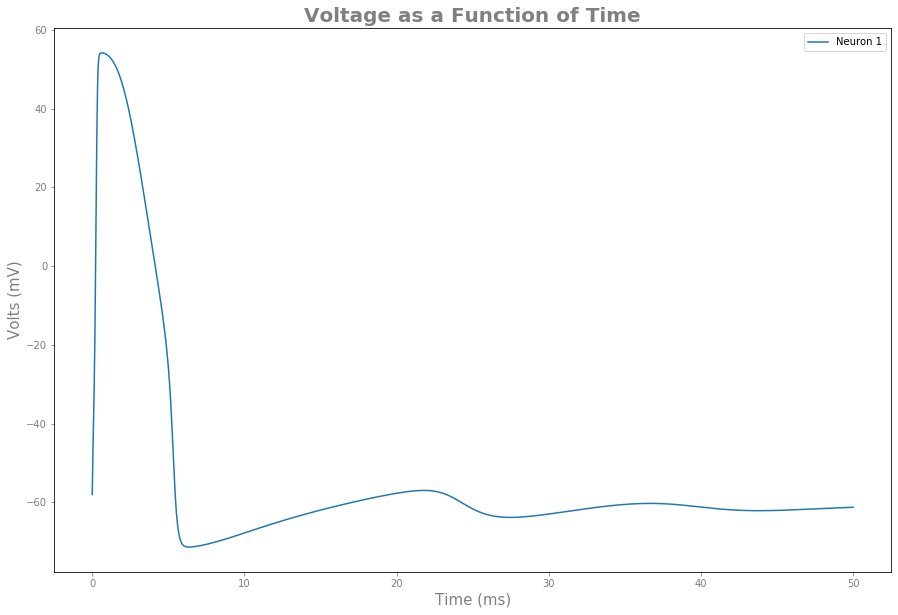

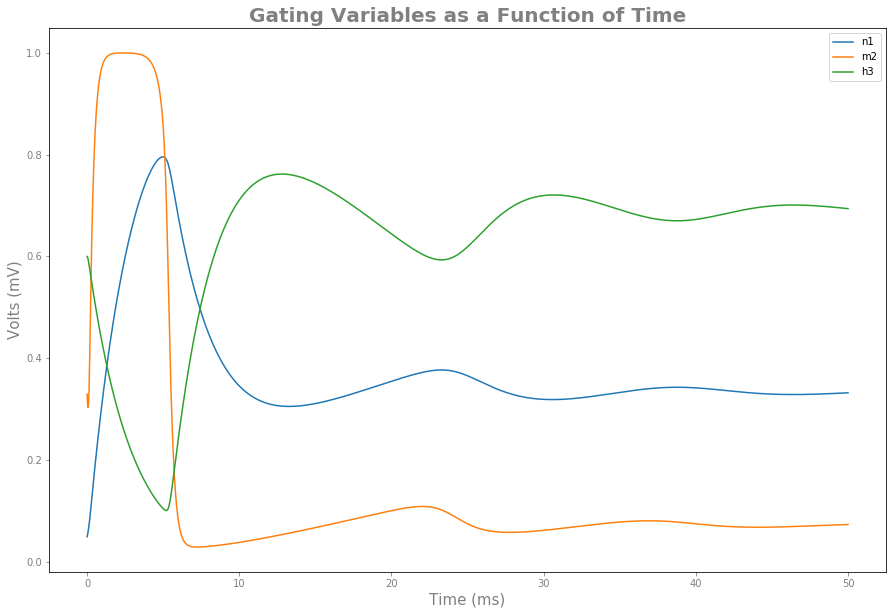

In [11]:
print("Burn in run, looking for NO oscillations")
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

#How many nodes are you using?
numNodes = 1
node1 = node1Base + ([0]*(numNodes-1))

node1 = np.array(node1)
network_params = node1

#####################################################################################

x = odeint(odes_progen,network_params,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes,gatingVars=True)

#Now grab the burned in values from the previous run
network_params_BI = x[:,-1]

Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


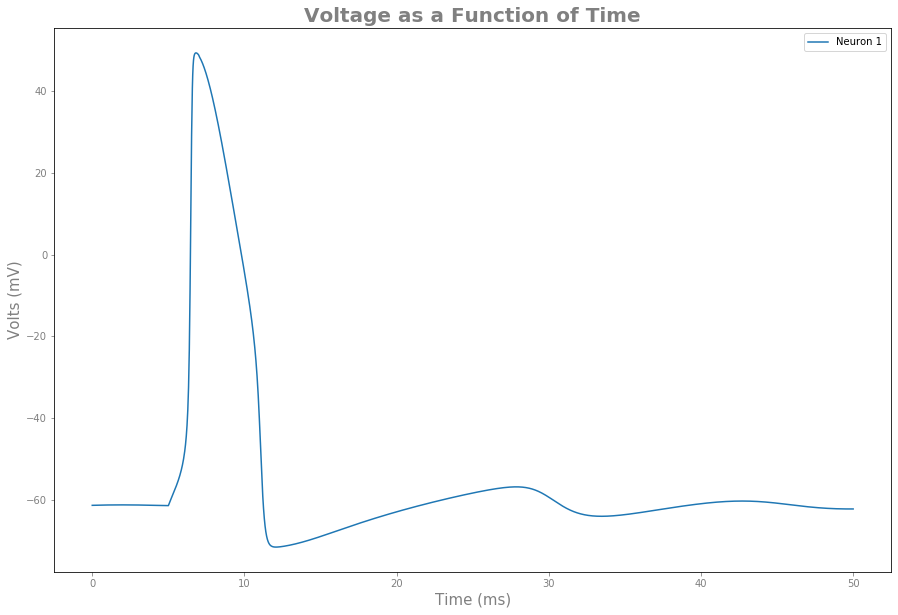

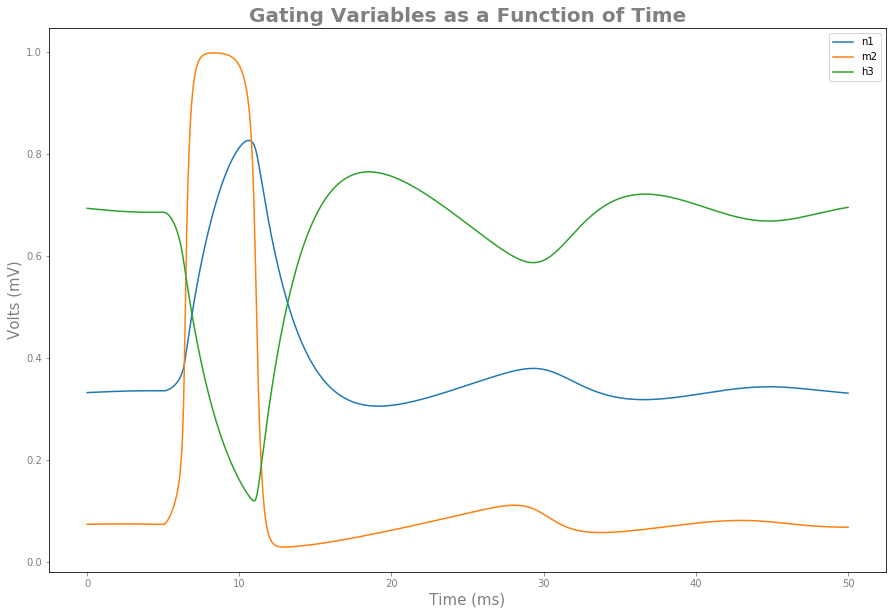

In [12]:
print("Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
x = odeint(odes_progen,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes,gatingVars=True)

## Things to Recall about Synaptic Coupling

1. Technically, the synaptic coupling variable s goes to the other neuron...
    - So either need to find some way to connect neurons (i.e. actually tell which is connected to which...) or just "built this in" such that the s fed in through the parameters is the "correct" s (i.e. already "switched"...)
2. Had to turn off the current for neuron 2 in order to get oscillations...  How does this generalize to more than 2 neurons? Does only 1 recieve current?
3. Need to set ES values somewhere, currently they're all just zero...

## Case 2: 2 Neurons

Burn in run, looking for NO oscillations OR globally stable oscillations


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


(44, 2000)


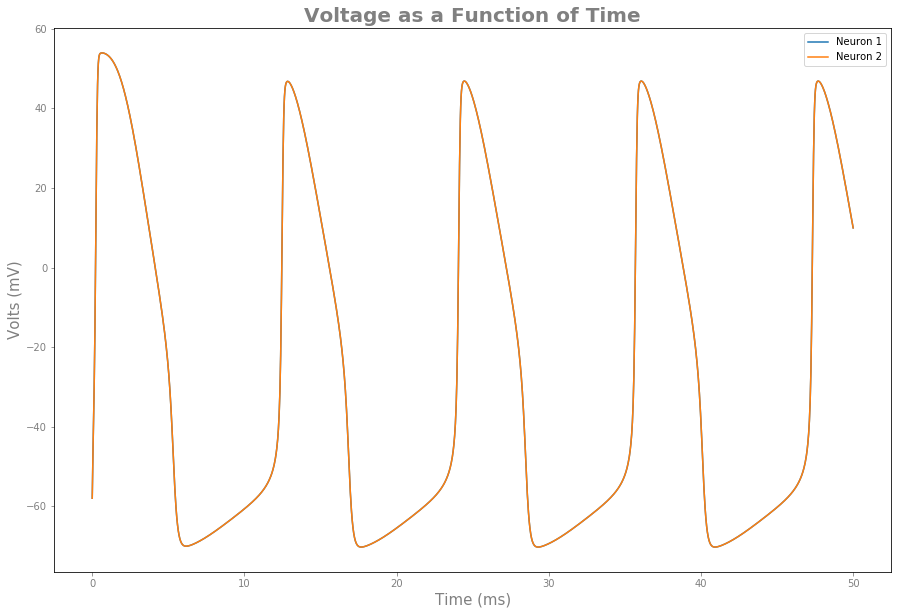

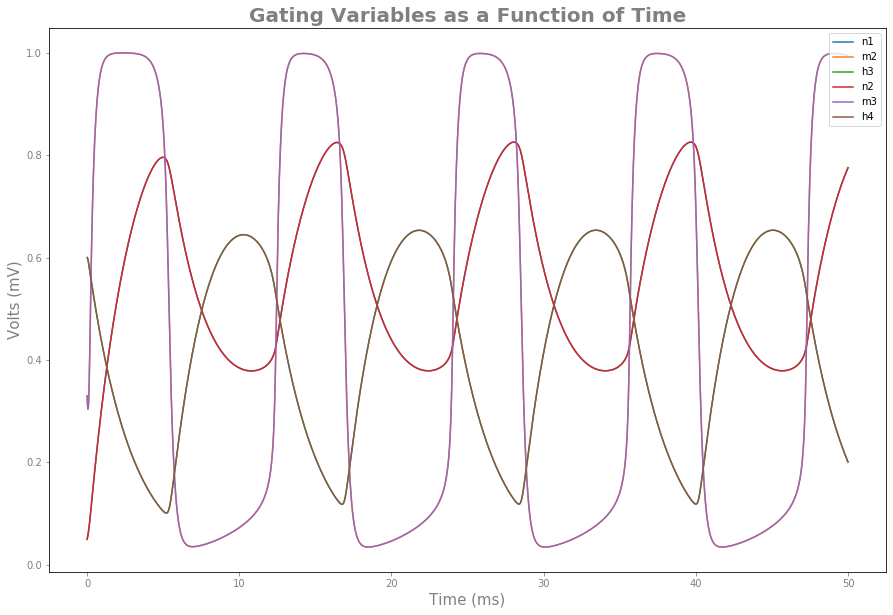

In [34]:
print("Burn in run, looking for NO oscillations OR globally stable oscillations")
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

#How many nodes are you using?
numNodes = 2
node1 = node1Base + ([0]*(numNodes-1))
node2 = node1

node1 = np.array(node1)
node2 = np.array(node2)
network_params = np.concatenate((node1, node2), axis=0)
#####################################################################################

x = odeint(odes_progen,network_params,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes,gatingVars=True)

#Now grab the burned in values from the previous run
network_params_BI = x[:,-1]

Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


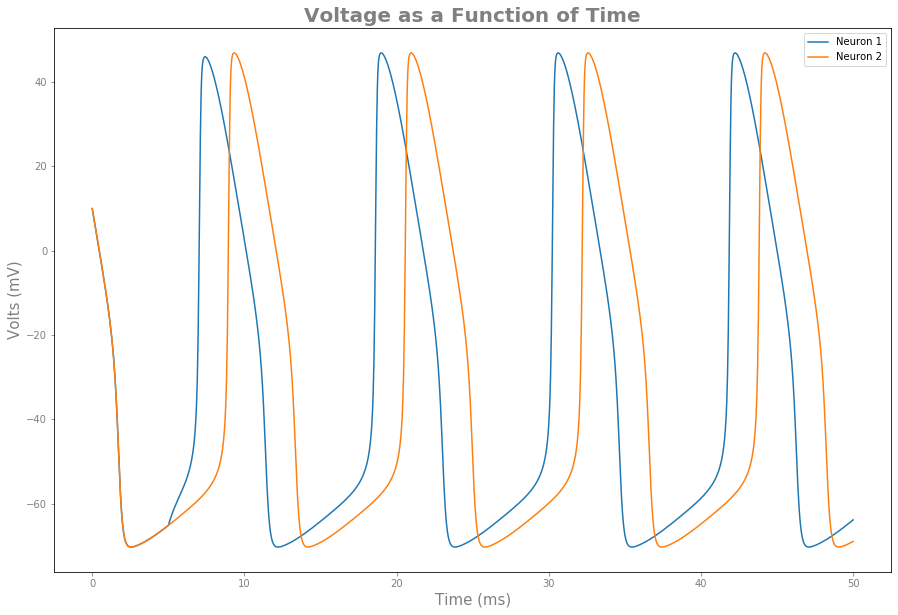

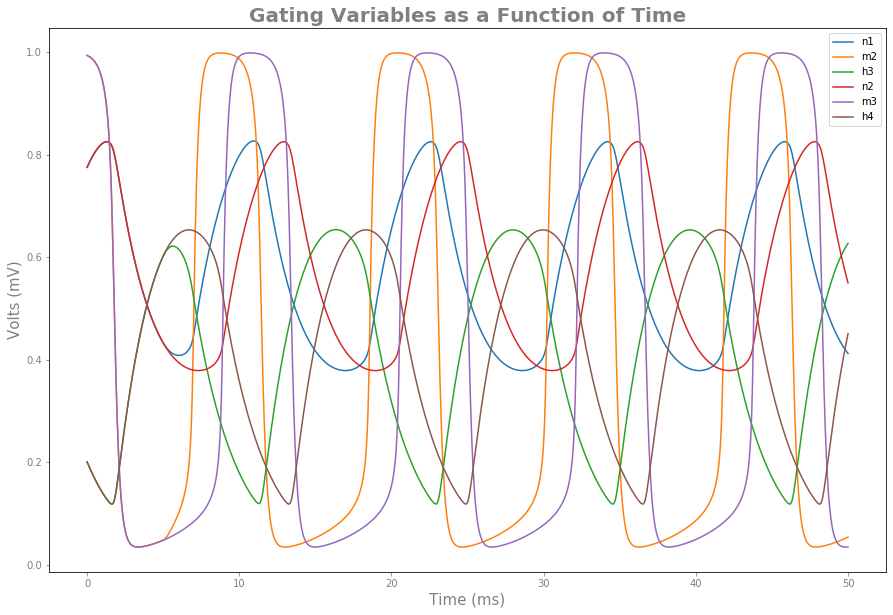

In [35]:
print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
x = odeint(odes_progen,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes,gatingVars=True)

## Case 3: 3 Neurons

Burn in run, looking for NO oscillations OR globally stable oscillations


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


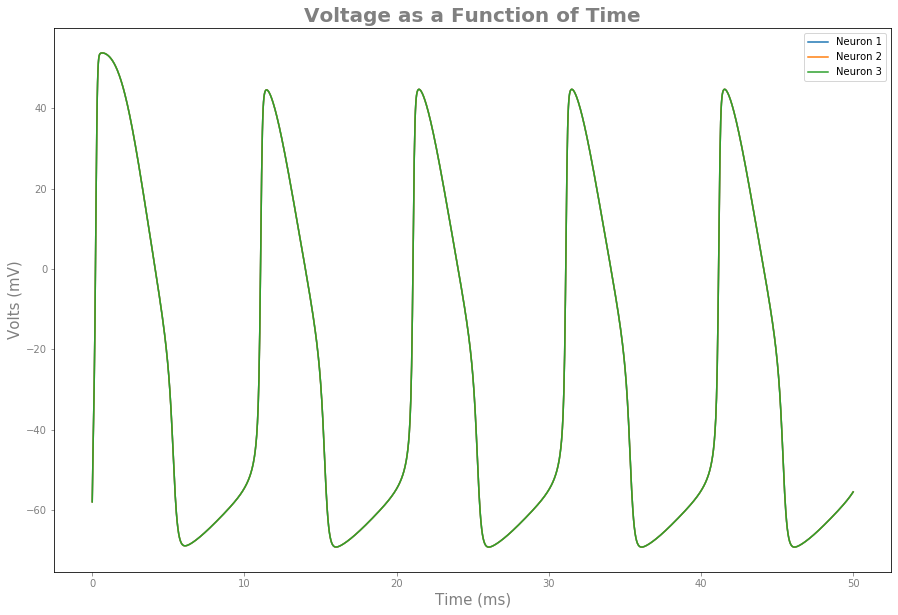

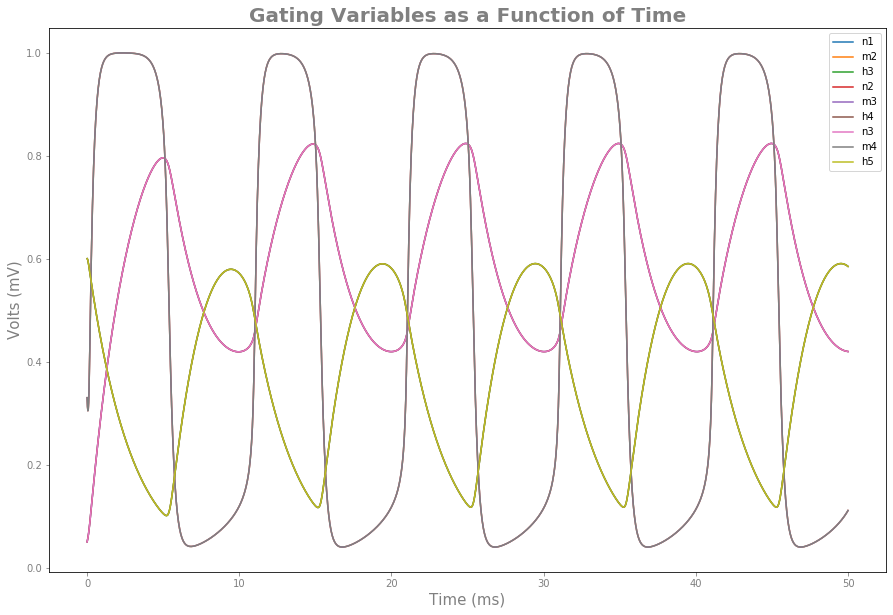

In [10]:
print("Burn in run, looking for NO oscillations OR globally stable oscillations")
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

#How many nodes are you using?
numNodes = 3
node1 = node1 + ([0]*(numNodes-1))
node1 = np.array(node1)
node2 = node1
node3 = node1

network_params = np.concatenate((node1, node2, node3), axis=0)
#####################################################################################

x = odeint(odes_progen,network_params,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes,gatingVars=True)

#Now grab the burned in values from the previous run
network_params_BI = x[:,-1]

Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


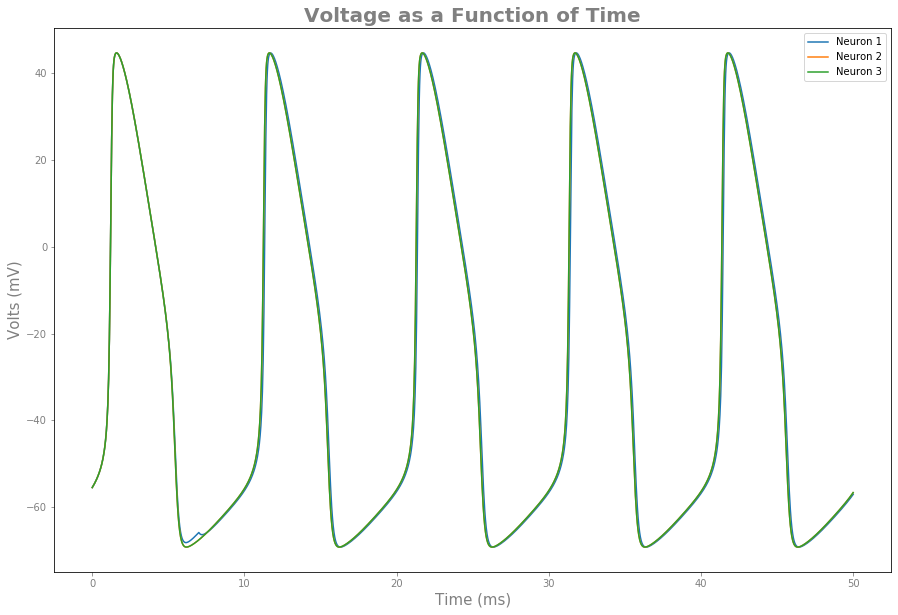

In [11]:
print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
x = odeint(odes_progen,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes)

## Case Z: 10 Neuron Run; Linear Network

Burn in run, looking for NO oscillations OR globally stable oscillations


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


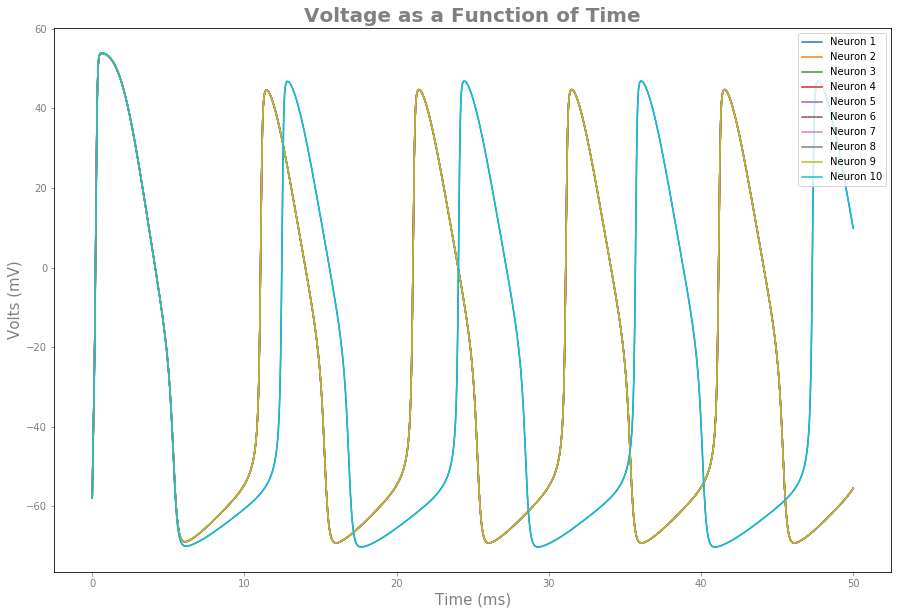

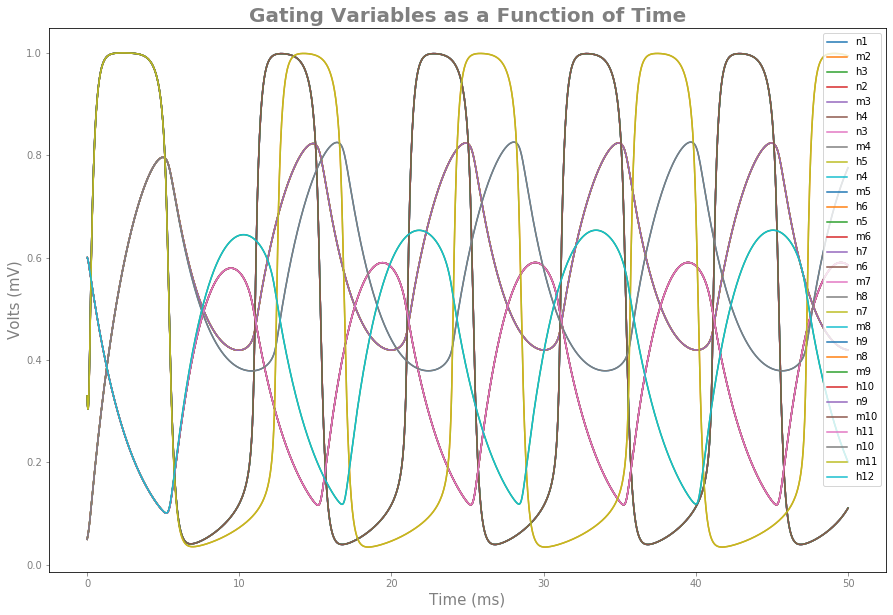

In [12]:
print("Burn in run, looking for NO oscillations OR globally stable oscillations")
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

#How many nodes are you using?
numNodes = 10
node1 = node1Base + ([0]*(numNodes-1))
network_params = node1*numNodes

x = odeint(odes_progen,network_params,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes,gatingVars=True)

#Now grab the burned in values from the previous run
network_params_BI = x[:,-1]

Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


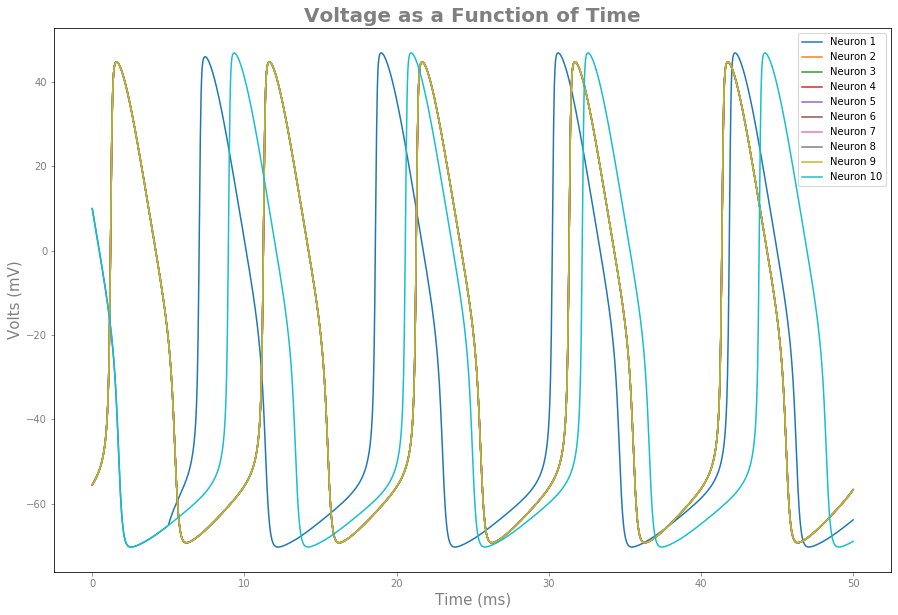

In [13]:
print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
x = odeint(odes_progen,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes)

Actual run, but with NO current.  Oscillations expected


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


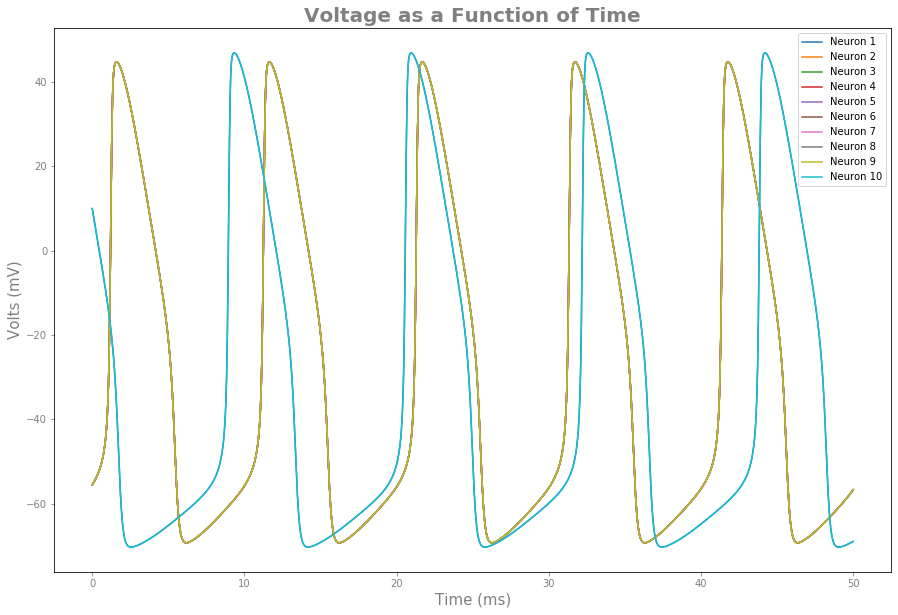

In [14]:
print("Actual run, but with NO current.  Oscillations expected")
#BURNED IN initial condition
vI = [0,0,0]
x = odeint(odes_progen,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes)

## Checking which spikes are overlapping the entire time
> It is neurons 1 and 10, and then neurons 2-9 that form the 2 sets of APs.  This makes sense since the current configuration has the neurons coupled together in a line, and neurons 1 and 10 are the "edge cases" with only 1 connection instead of 2 like the rest.

For reference (ICs from the cell above)
1. 9.966703459062506
2. -55.536381167270434
3. -55.536381167270434
4. -55.536381167270434
5. -55.536381167270434
6. -55.536381167270434
7. -55.536381167270434
8. -55.536381167270434
9. -55.536381167270434
10. 9.966703459062506

## Investigating the Effects of No Current Using Burned In Conditions
> All these runs are globally stable when oscillating

Burn in run, looking for NO oscillations


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


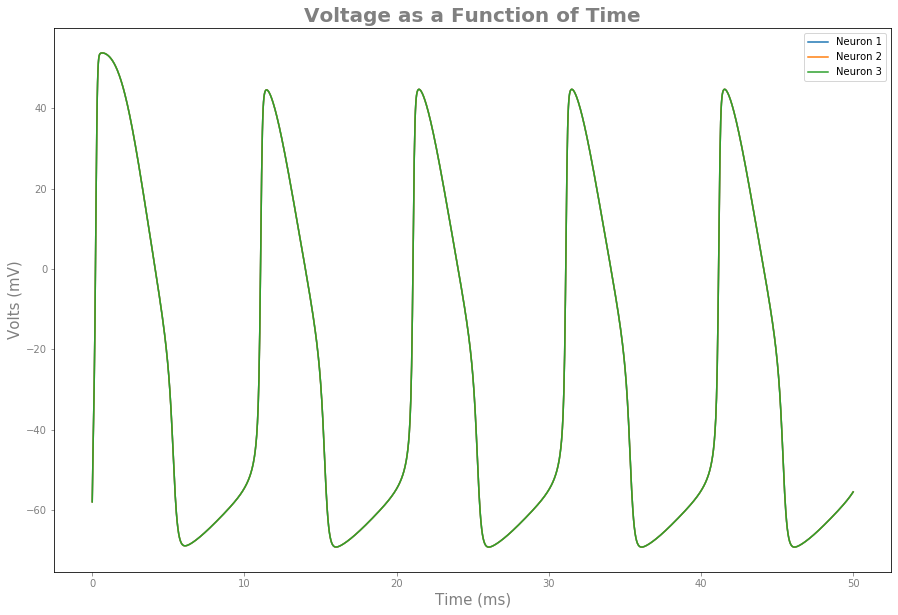

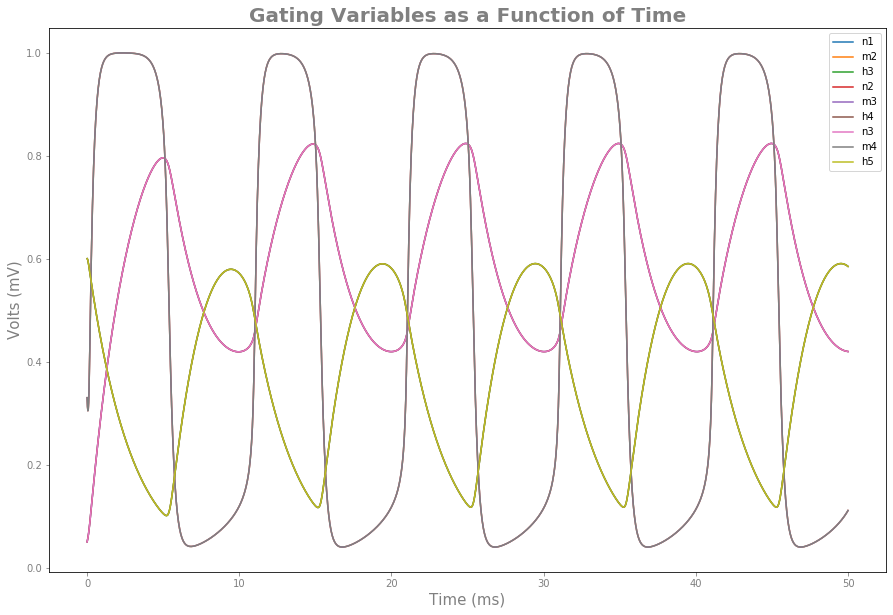

Actual run, using NO CURRENT.  Oscillations expected for Neurons?


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


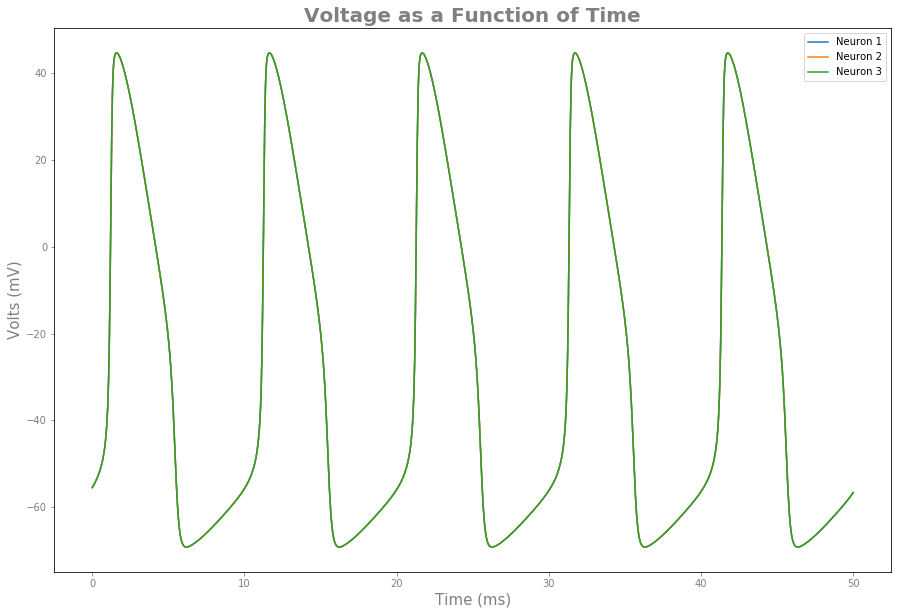

In [11]:
print("Burn in run, looking for NO oscillations")
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]
#How many nodes are you using?
numNodes = 3
node1 = node1Base + ([0]*(numNodes-1))
network_params = node1*numNodes
#####################################################################################
x = odeint(odes_progen,network_params,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes,gatingVars=True)

#Now grab the burned in values from the previous run
network_params_BI = x[:,-1]
print("Actual run, using NO CURRENT.  Oscillations expected for Neurons?")
#BURNED IN initial condition
vI = [0,0,0]
x = odeint(odes_progen,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,numNodes)